In [1]:
import boto3
import pandas as pd
from sagemaker import get_execution_role

role = get_execution_role()
bucket = 'projet-cobalt'
data_key = 'Enefit/train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)

## Load and save data

# data = pd.read_csv(data_location)
# data.head()

# consumption = data[data["is_consumption"]==1]
# consumption.to_csv("data/consumption.csv")

# production = data[data["is_consumption"]==0]
# production.to_csv("data/production.csv")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Data setup

In [2]:
df = pd.read_csv(
    "data/consumption.csv", usecols=["prediction_unit_id", "datetime", "target"]
)[["prediction_unit_id", "datetime", "target"]].rename(
    columns={"prediction_unit_id": "unique_id", "datetime": "ds", "target": "y"}
)
df["ds"] = pd.to_datetime(df["ds"])
df.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


# Filling NaN values

In [3]:
df.isna().sum()

unique_id      0
ds             0
y            264
dtype: int64

In [4]:
df["y"] = df["y"].interpolate(method="linear")
df.isna().sum()

unique_id    0
ds           0
y            0
dtype: int64

# Train/Test split

In [9]:
# taking the last 48 hours for test
for i in df["unique_id"].unique():
    if i == df["unique_id"].unique()[0]:
        df_test = df[df["unique_id"]==i][-48:]
        continue
    df_test = pd.concat([df_test, df[df["unique_id"]==i][-48:]])
    
df_test.sort_index(inplace=True)
print(df_test.shape)
df_test.head()

(3312, 3)


,unique_id,ds,y
906150,26,2023-03-28 00:00:00,5.137
906217,26,2023-03-28 01:00:00,4.212
906284,26,2023-03-28 02:00:00,4.917
906351,26,2023-03-28 03:00:00,4.195
906418,26,2023-03-28 04:00:00,4.518


In [10]:
train_idx = [idx for idx in df.index if idx not in df_test.index]
df_train = df.loc[train_idx]
df_train.shape
df_train.head()

,unique_id,ds,y
0,0,2021-09-01,96.590
1,1,2021-09-01,17.314
2,2,2021-09-01,656.859
3,3,2021-09-01,59.000
4,4,2021-09-01,501.760


In [11]:
df.shape[0] == df_train.shape[0] + df_test.shape[0]

True

In [12]:
df.shape[1] == df_train.shape[1] == df_test.shape[1]

True

# Installing NeuralForecast

In [5]:
!pip install neuralforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.5/193.5 kB 3.2 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 22.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.1/65.1 MB 9.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.1/385.1 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 122.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 36.3 MB/s eta 0:00:00
   ━━━━━━━━

# Model Training

In [6]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN

horizon = 48

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=200,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=32,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=32,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=horizon,      # Length of input sequence
                max_steps=50,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='h')


Seed set to 1
Seed set to 1


In [7]:
%%time
nf.fit(df)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

CPU times: user 32.2 s, sys: 985 ms, total: 33.2 s
Wall time: 59.1 s


In [8]:
# import torch
# torch.cuda.empty_cache()

In [9]:
# import gc
# del variables
# gc.collect()

In [10]:
# print(torch.cuda.memory_summary(device=None, abbreviated=True))

# Prediction

In [17]:
df_hat = nf.predict()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [18]:
df_hat.reset_index(inplace=True)
df_hat.head()

,unique_id,ds,LSTM,NHITS
0,0,2023-06-01 00:00:00,537.161804,512.904175
1,0,2023-06-01 01:00:00,424.805878,510.907562
2,0,2023-06-01 02:00:00,415.020782,491.876892
3,0,2023-06-01 03:00:00,377.705597,485.201843
4,0,2023-06-01 04:00:00,322.458832,445.163025


# Save model

In [15]:
nf.save(path='./checkpoints/test_run/',
        model_index=None, 
        overwrite=True,
        save_dataset=True)

# Load model

In [6]:
from neuralforecast import NeuralForecast

nf2 = NeuralForecast.load(path='./checkpoints/test_run/')
df_hat2 = nf2.predict().reset_index()
df_hat2.head()

Seed set to 1
Seed set to 1


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

,unique_id,ds,LSTM,NHITS
0,0,2023-06-01 00:00:00,537.161804,512.904175
1,0,2023-06-01 01:00:00,424.805878,510.907562
2,0,2023-06-01 02:00:00,415.020782,491.876892
3,0,2023-06-01 03:00:00,377.705597,485.201843
4,0,2023-06-01 04:00:00,322.458832,445.163025


In [19]:
df_hat2 == df_hat

,unique_id,ds,LSTM,NHITS
0,True,True,True,True
1,True,True,True,True
2,True,True,True,True
3,True,True,True,True
4,True,True,True,True
...,...,...,...,...
3307,True,True,True,True
3308,True,True,True,True
3309,True,True,True,True
3310,True,True,True,True


# Plot predictions

In [5]:
# df_hat.to_csv("data/df_hat.csv", index=False)

In [13]:
df_hat = pd.read_csv("data/df_hat.csv")
df_hat.head()

,unique_id,ds,LSTM,NHITS
0,0,2023-06-01 00:00:00,537.16180,512.90420
1,0,2023-06-01 01:00:00,424.80588,510.90756
2,0,2023-06-01 02:00:00,415.02078,491.87690
3,0,2023-06-01 03:00:00,377.70560,485.20184
4,0,2023-06-01 04:00:00,322.45883,445.16302


In [7]:
!pip install utilsforecast

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 kB 5.8 MB/s eta 0:00:00


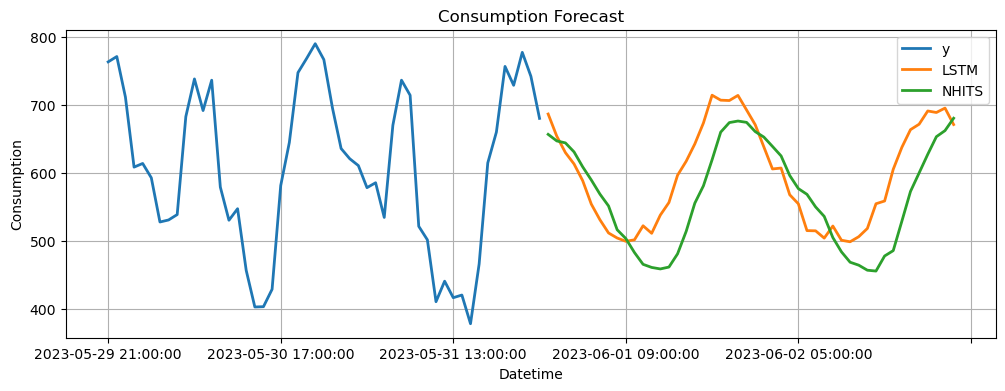

In [14]:
import random
import pandas as pd
import matplotlib.pyplot as plt
random.seed(0)

plot_id = random.randint(0, len(df["unique_id"].unique()))
fig, ax = plt.subplots(figsize=(12, 4))
# Concatenate the end of train and forecast dataframes
df_end = df[-(df_hat.shape[0]):]
plot_df = pd.concat([df_end[df_end["unique_id"]==plot_id], df_hat[df_hat["unique_id"]==plot_id]]).set_index('ds')
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)
ax.set_title('Consumption Forecast')
ax.set_ylabel('Consumption')
ax.set_xlabel('Datetime')
ax.legend()
ax.grid()

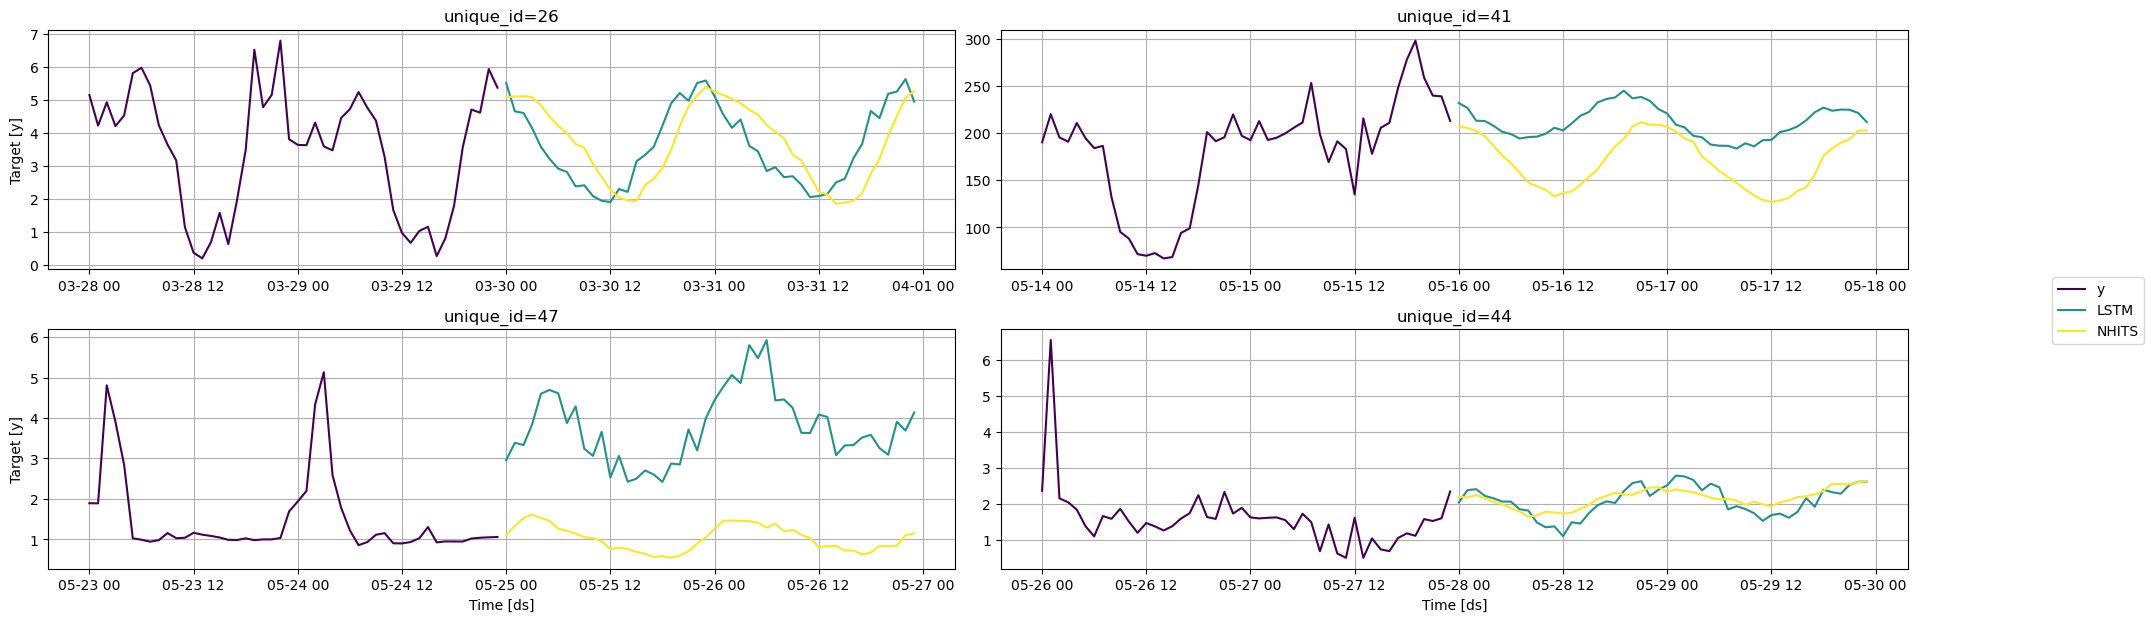

In [19]:
from utilsforecast.plotting import plot_series

# taking the last 72 hours for plotting
for i in df["unique_id"].unique():
    if i == df["unique_id"].unique()[0]:
        last_72 = df[df["unique_id"]==i][-72:]
        continue
    last_72 = pd.concat([df_test, df[df["unique_id"]==i][-72:]])
    
last_72.sort_index(inplace=True)

plot_series(last_72, df_hat, max_ids=4, plot_random=False)